In [2]:
"""
Daria Gileva, Brandon Nguyen, Karin Stoddart
CSE 163 AA

This file tests the methods in the script.
"""

import plotly.express as px
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


def extract_xlsx(xlsx_name, ws_name):
    """
    This function takes the path of a multi-sheet Excel workbook file and the
    name of the workshee of interest and returns a Pandas dataframe.
    """
    xlsx = pd.ExcelFile(xlsx_name)
    return pd.read_excel(xlsx, ws_name)


def merge_geo(shp_file_name, xlsx_file=None,
              csv_file_name=None):
    """
    This function takes the name of the shapes file and Excel workbook file OR
    a CSV file and returns a geospatial dataframe that joins these two datasets
    by state.
    """
    shp_file = gpd.read_file(shp_file_name)
    is_mainland = (shp_file['STUSPS'] != 'AK') & \
                  (shp_file['STUSPS'] != 'HI') & \
                  (shp_file['STUSPS'] != 'GU') & \
                  (shp_file['STUSPS'] != 'PR') & \
                  (shp_file['STUSPS'] != 'MP') & \
                  (shp_file['STUSPS'] != 'AS') & \
                  (shp_file['STUSPS'] != 'VI')
    shp_file = shp_file[is_mainland]

    if xlsx_file is None:
        csv_file = pd.read_csv(csv_file_name)
        csv_file = csv_file[
            (csv_file["State Name"] != "Alaska") &
            (csv_file["State Name"] != "Hawaii")
        ]
        merged_data = shp_file.merge(csv_file, left_on='STUSPS',
                                     right_on='State', how='outer')
    else:
        merged_data = shp_file.merge(xlsx_file, left_on="NAMELSAD",
                                     right_on="Location")
    return merged_data



In [21]:
# Loading in the overdose data
xlsx_file = extract_xlsx("test/OverdoseDeathWA_test.xlsx", "By Location and Date")
wa_geo_data = merge_geo("test/geodata/cb_2022_us_county_500k.shp", xlsx_file)
national_geo_data = merge_geo("test/geodata/cb_2022_us_county_500k.shp", csv_file_name="test/NationalOverdose_test.csv")

In [24]:
# (1) How has the number of drug overdose cases changed between 2016 and 2023
# in Washington State?
def wa_overdose_change(wa_geo_data: gpd.GeoDataFrame,
                       start: float = 2016.0,
                       end: float = 2022.0) -> None:
    """
    This function takes in the geospatial dataframe and returns the number
    of drug overdose cases in Washington from 2016-2023.
    """
    wa_data = wa_geo_data[wa_geo_data["STATE_NAME"] == "Washington"].copy()
    drug = wa_data["Drug Category"] == "Any Drug"
    county = wa_data["Geography"] == "County"
    wa_data["Year"] = pd.to_numeric(wa_geo_data["Year"], errors="coerce")
    year = (wa_data["Year"] >= start) & (wa_data["Year"] <= end)
    time = wa_data["Time Aggregation"] == "1 year rolling counts"
    remove_star = wa_data["Death Count"] != "*"
    county_data = wa_data[drug & county & time & year & remove_star].copy()
    county_data["Death Count"] = county_data["Death Count"].astype("int")
    county_data = \
        county_data.groupby("Year").agg({"Death Count": "sum"}).reset_index()

    fig = px.line(
        county_data,
        x="Year",
        y="Death Count",
        title=f"Drug Overdose Deaths in WA between "
        f"{int(start)} and {int(end)}",
        markers=True
    )
    fig.update_layout(title_x=0.5, title_y=0.95, font=dict(size=15))
    fig.update_traces(line=dict(width=4), marker=dict(size=10))

    fig.show()
    # fig.write_image('wa_overdose_test.png')

In [25]:
 wa_overdose_change(wa_geo_data)

In [9]:
#  (2) Which counties in Washington state have the highest number/rate
#  of drug overdose cases?
def overdose_deaths_counties(data: gpd.GeoDataFrame, drug_name='Any Drug',
                             year_start=2016.0, year_end=2022.0) -> None:
    """
    This function takes in the geospatial dataframe and plots the drug
    overdose cases in different counties in Washington.
    """
    data = data[data['STATE_NAME'] == 'Washington'].copy()
    drug = data['Drug Category'] == drug_name
    county = data['Geography'] == 'County'
    time = (data['Time Aggregation'] == '1 year rolling counts')
    remove_star = data['Death Count'] != '*'
    county_data = data[drug & county & time & remove_star].copy()
    county_data['Death Count'] = county_data['Death Count'].astype('int')

    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.2)
    plt.suptitle("Washington County Overdose Deaths", fontsize=18, y=0.95)
    n = int(year_end - year_start)
    height, width = n // 2 + 1, 2
    for i in range(int(year_start), int(year_end)+1):
        year = (county_data['Year'] == i)
        year_data = county_data[year]

        ax = plt.subplot(height, width, i - int(year_start)+1)

        data.plot(ax=ax, color='#d3d3d3')
        year_data.plot(ax=ax, column='Death Count', legend=True)
        ax.set_title(i)
        ax.set_aspect('equal')
    plt.savefig('counties_overdose_test.png')

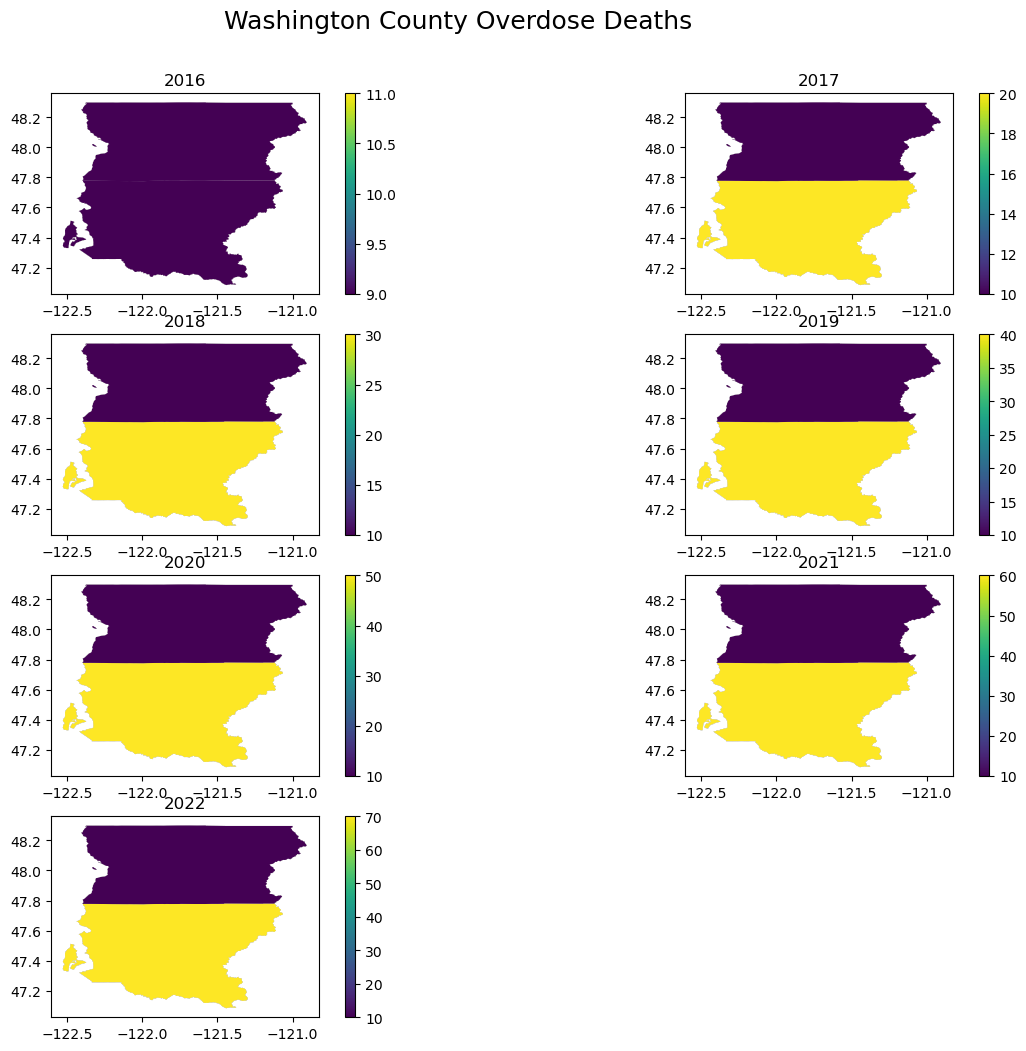

In [10]:
overdose_deaths_counties(wa_geo_data)

In [22]:
# (3) How does the number of overdoses in WA compare to number of overdoses in
# other states in the USA? - Brandon
def wa_versus_us(national_geo_data: gpd.GeoDataFrame) -> None:
    """
    This function takes in the national drug overdose dataset and plots
    the number of drug overdose deaths across the U.S. in 2022.
    """
    shp_file = gpd.read_file('Data/geodata/cb_2022_us_county_500k.shp')
    is_mainland = (shp_file['STUSPS'] != 'AK') & \
                  (shp_file['STUSPS'] != 'HI') & \
                  (shp_file['STUSPS'] != 'GU') & \
                  (shp_file['STUSPS'] != 'PR') & \
                  (shp_file['STUSPS'] != 'MP') & \
                  (shp_file['STUSPS'] != 'AS') & \
                  (shp_file['STUSPS'] != 'VI')
    shp_file = shp_file[is_mainland]

    usa_data = national_geo_data[['State', 'Year', 'Month', 'Period',
                                  'Indicator', 'Data Value',
                                  'geometry']].copy()
    usa_data['Year'] = usa_data['Year'].astype(str)
    usa_data['Data Value'] = usa_data['Data Value'].str.replace(',', '')
    usa_data['Data Value'] = usa_data['Data Value'].fillna('0').astype(float)

    # Create masks
    any_drug = (usa_data['Indicator'] == 'Number of Drug Overdose Deaths')
    year = (usa_data['Year'] == '2022')
    month = (usa_data['Month'] == 'December')
    states = (usa_data['State'] != 'AK') & (usa_data['State'] != 'HI') & \
             (usa_data['State'] != 'YC') & (usa_data['State'] != 'US')

    # Filter data
    usa_data = usa_data[any_drug & year & month & states]

    # Plot data
    fig, ax = plt.subplots(1, figsize=(15, 7))
    shp_file.plot(ax=ax, color='#EEEEEE')
    usa_data.plot(ax=ax, column='Data Value', legend=True)
    plt.title('National Drug Overdose Deaths in 2022', fontsize=16)
    plt.savefig('wa_versus_us_test.png')

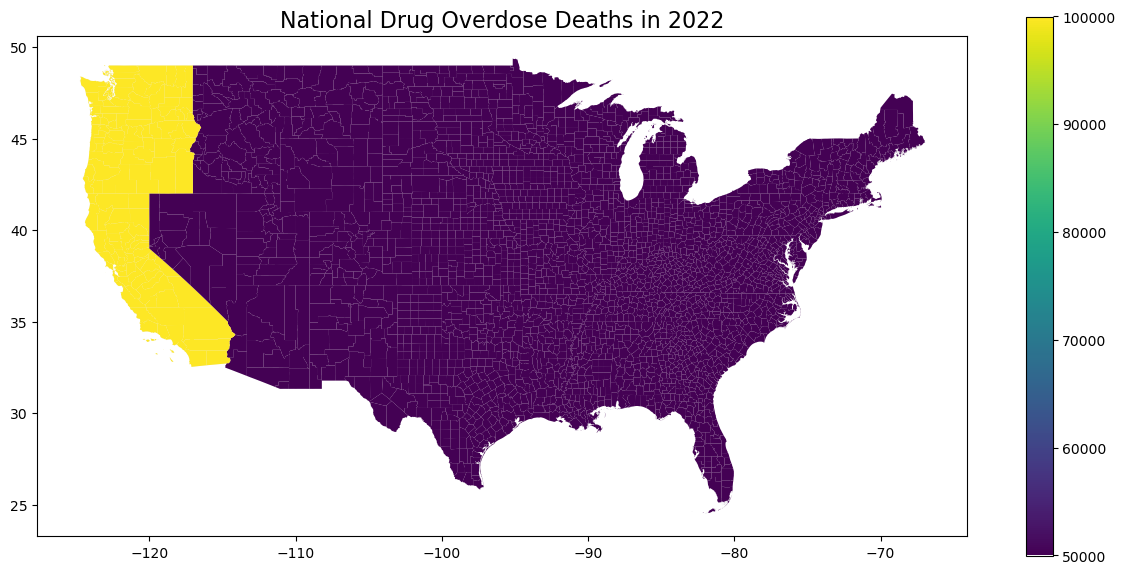

In [23]:
wa_versus_us(national_geo_data)